# Implementazione di un modello ad alta risoluzione innestato per lo studio della corrente della Florida
Federica Benassi, Beatrice Biagi, Serena Negroni, Deniel Pavone, Chiara Ventrucci

In [1]:

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from scipy import interpolate

In [33]:
def set_plot():
    fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree()), figsize = [12,12])
    
    font_size = 15

    ax.coastlines(resolution="10m", linewidths=0.5)
    ax.add_feature(cfeature.LAND.with_scale("10m"),
               edgecolor='lightgray',facecolor='lightgray',
               zorder=0)

    ax.tick_params(axis = "both", labelsize = 15)

    gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5,
                  linestyle='--',draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False

    gl.xlabel_style = {'fontsize': font_size}
    gl.ylabel_style = {'fontsize': font_size}

    return (fig, ax)

def set_cbar(c, title):
    cbar = plt.colorbar(c, pad = 0.05, orientation = "horizontal")
    cbar.ax.tick_params(labelsize = 15)
    cbar.set_label(label = title, size = 20)
    return cbar

def title_set(ax, title):
    ax.set_title(title, fontsize = 25, y=1.05)

# def set_quivers(ax, lon, lat, u, v, step=3, scale=15):
#     # plot a 2D field of arrows
#     skip=(slice(None,None,step),slice(None,None,step))
#     Q = ax.quiver(lon[skip],lat[skip],
#                 u[skip],v[skip],
#                 pivot='middle',linewidth=0.05,
#                 headwidth=2.0, scale=scale, headlength=2,
#                 zorder=2)

#     # Draw legend for vector plot
#     qk = ax.quiverkey(Q, 0.95, 1.02, 1, r'1 m/s',
#                     labelpos='E', coordinates='axes')
                    
def set_streamlines(ax, lon, lat, u, v, density=3):
    sp = ax.streamplot(lon, lat, u, v, linewidth=0.7, arrowsize=0.8,
                    density=density, color='black', transform=ccrs.PlateCarree())



# Correnti superficiali

## Modello child

In [34]:
#open NetCDF file
pathname = "."
file_nc = "SURF_1h_20210202_20210206_grid_U.nc"
u_file = Dataset(pathname + "/" + file_nc, 'r')

file_nc2 = "SURF_1h_20210202_20210206_grid_V.nc"
v_file = Dataset(pathname + "/" + file_nc2, 'r')

#read mask values
file_mask = 'mesh_mask.nc'
ds_mask = Dataset(file_mask, 'r')
#take variables at the surface
lon_T= ds_mask.variables['glamt'][0,:,:] #????
lat_T= ds_mask.variables['gphit'][0,:,:]
mask_T = ds_mask.variables['tmask'][0,0,:,:]
mask_U = ds_mask.variables['umask'][0,0,:,:]
mask_V = ds_mask.variables['vmask'][0,0,:,:] 

#read lat, lon 
lon_u = u_file.variables['nav_lon'][:,:]
lat_u = u_file.variables['nav_lat'][:,:]

lon_v = v_file.variables['nav_lon'][:,:]
lat_v = v_file.variables['nav_lat'][:,:]

vel_U = np.where(mask_U==0, np.nan,
                  u_file.variables['vozocrtx'][96:,0,:,:]) #zonal current
vel_V = np.where(mask_V==0, np.nan,
                  v_file.variables['vomecrty'][96:,0,:,:]) #meridional current

u = np.mean(vel_U, axis = 0)
v = np.mean(vel_V, axis = 0)

#--------------------------------------------
# Interpolate vel component from UV to T grid points
# and compute Speed grid center??
#--------------------------------------------
velU_T=interpolate.griddata((lon_u.flatten(),lat_u.flatten()),
         u.flatten(), (lon_T,lat_T), method='linear')
velV_T=interpolate.griddata((lon_v.flatten(),lat_v.flatten()),
         v.flatten(), (lon_T,lat_T), method='linear')

speed_child = np.where(mask_T==0, np.nan,
        np.sqrt(np.square(velU_T[:,:]) + np.square(velV_T[:,:])))

u_child, v_child = np.copy(velU_T), np.copy(velV_T)

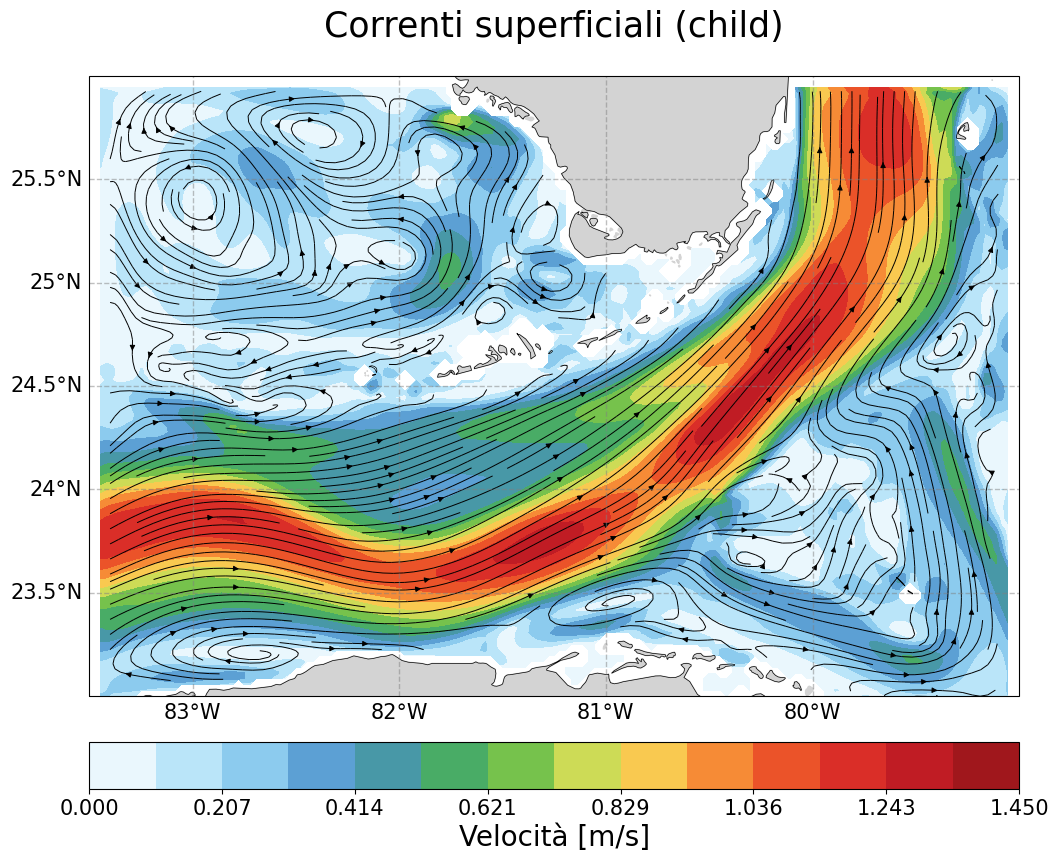

In [36]:
fig, ax = set_plot()

# plot a 2D speed field as contours
# Create the colormap
colors = [tuple(np.array((255,255,255))/255), # white
          tuple(np.array((157,218,247))/255), # blue
          tuple(np.array((72,142,202))/255),  # dark blue
          tuple(np.array((73,181,70))/255),   # green
          tuple(np.array((250,232,92))/255),  # yellow
          tuple(np.array((245,106,41))/255),  # orange
          tuple(np.array((211,31,40))/255),   # red
          tuple(np.array((146,21,25))/255)]   # dark red
mycmap = LinearSegmentedColormap.from_list('WhiteBlueGreenYellowRed', colors, N=100)
#mycmap = plt.get_cmap('rainbow')
vmin,vmax = 0.0, 1.45
levels = np.linspace(vmin, vmax, 15)
cf = ax.contourf(lon_T, lat_T, speed_child,
                 levels=levels, vmin=vmin,vmax=vmax,
                 cmap=mycmap, transform=ccrs.PlateCarree())

cb = set_cbar(cf, "Velocità [m/s]")
#cb.ax.set_title("Velocità (m/s)")
#set_streamlines(ax, lon_T, lat_T, velU_T, velV_T)
set_streamlines(ax, lon_T, lat_T, u_child, v_child)

title_set(ax, "Correnti superficiali (child)")

ax.set_ylim([23, 26])
ax.set_xlim([-83.5, -79])

fig.savefig('seaSurfCurrent_child.pdf',bbox_inches='tight')

## Modello parent

In [23]:
#open NetCDF file
pathname = "./oceanBC"
file_nc = "20210209_d-MERCATOR_an-fv01.nc"
ncin = Dataset(pathname + "/" + file_nc, 'r')


#read lat, lon e temp
lon = ncin.variables['longitude'][:]
lat = ncin.variables['latitude'][:]

u = ncin.variables['uo'][0,0,:,:]
v = ncin.variables['vo'][0,0,:,:]

speed_parent = np.sqrt(np.square(u[:,:]) + np.square(v[:,:]))

#lat e laon 2d
lat_2d = np.zeros([48,63])
for i in range(0,63):
    lat_2d[:,i] = lat
    

lon_2d = np.zeros([48,63])
for i in range(0,48):
    lon_2d[i,:] = lon

u_parent = np.copy(u)
v_parent = np.copy(v)

file_nc = "GLO-MFC_001_024_mask_bathy.nc"
ncin = Dataset(pathname + "/" + file_nc, 'r')
mask = ncin.variables["mask"][0,:,:]

u_parent = np.where((mask==0) | (mask == "--"), np.nan,
                  u_parent[:,:]) #zonal current
v_parent = np.where(mask==0, np.nan,
                  v_parent[:,:]) #meridional current

c:\Users\feder\miniconda3\lib\site-packages\numpy\ma\core.py:4078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = compare(sdata, odata)


In [24]:
u_parent.shape

(48, 63)

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


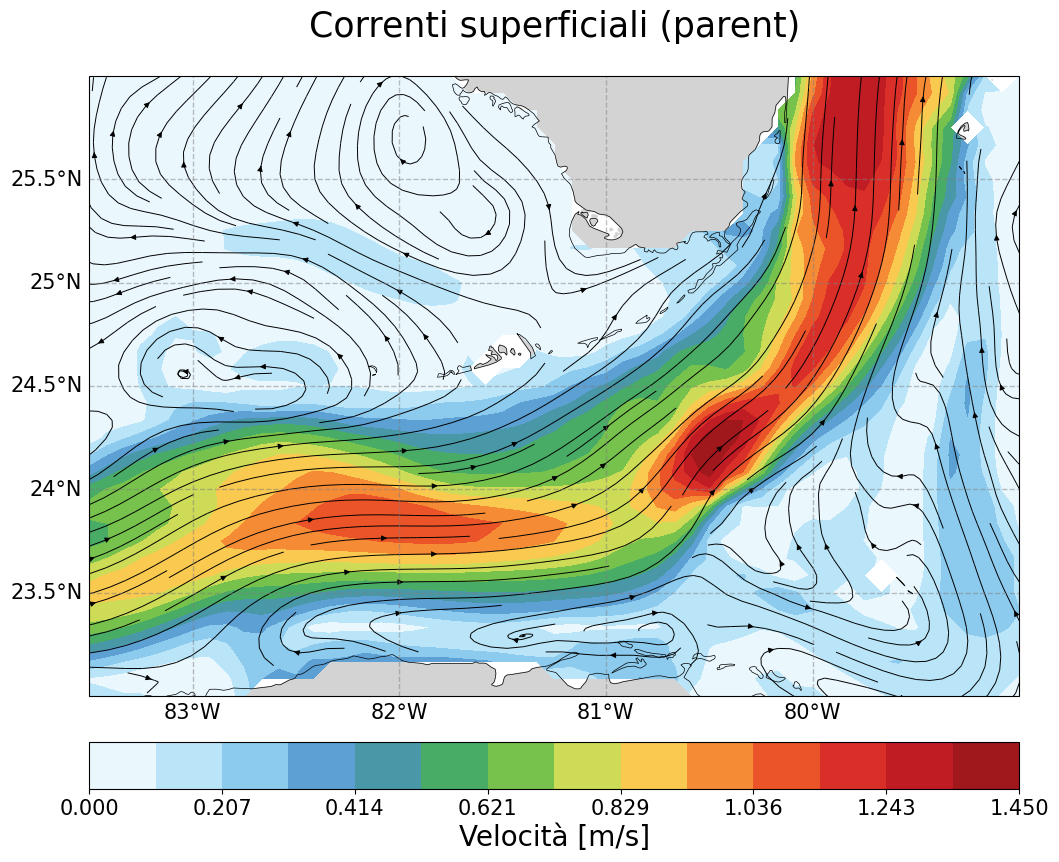

In [25]:
fig, ax = set_plot()

# plot a 2D speed field as contours
# Create the colormap
colors = [tuple(np.array((255,255,255))/255), # white
          tuple(np.array((157,218,247))/255), # blue
          tuple(np.array((72,142,202))/255),  # dark blue
          tuple(np.array((73,181,70))/255),   # green
          tuple(np.array((250,232,92))/255),  # yellow
          tuple(np.array((245,106,41))/255),  # orange
          tuple(np.array((211,31,40))/255),   # red
          tuple(np.array((146,21,25))/255)]   # dark red
mycmap = LinearSegmentedColormap.from_list('WhiteBlueGreenYellowRed', colors, N=100)
vmin,vmax = 0.0, 1.45
levels = np.linspace(vmin, vmax, 15)
cf = ax.contourf(lon_2d, lat_2d, speed_parent,
                 levels=levels, vmin=vmin,vmax=vmax,
                 cmap=mycmap, transform=ccrs.PlateCarree())

cb = set_cbar(cf, "Velocità [m/s]")
set_streamlines(ax, lon_2d, lat_2d, u_parent, v_parent, density = 2)

title_set(ax, "Correnti superficiali (parent)")

ax.set_ylim([23, 26])
ax.set_xlim([-83.5, -79])

fig.savefig("seaSurfCurrent_parent.pdf", bbox_inches = "tight")

# Calcolo della vorticity

## Modello child

In [37]:
# CALCOLO DELLA VORTICITY

dx = np.diff(lon_T)[0,0]
dy = np.diff(lat_T, axis = 0)[0,0]


vort_child = np.zeros(u_child.shape)

du = np.zeros(u_child.shape)
dv = np.zeros(u_child.shape)


du[1:-1,:] = (u_child[2:,:] - u_child[:-2,:])/2
dv[:,1:-1] = (v_child[:,2:] - v_child[:,:-2])/2 
vort_child = (dv/dx - du/dy)/(np.pi*6371*1000)*180 

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


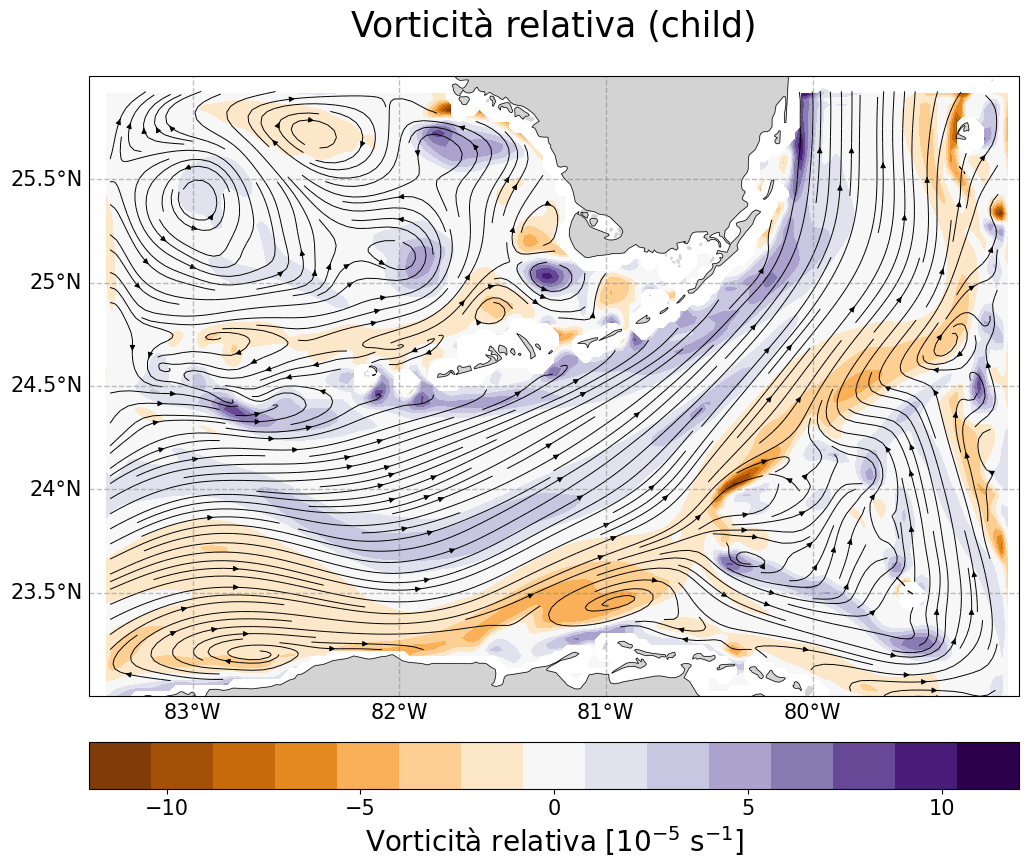

In [39]:
fig, ax = set_plot()
cmap = plt.get_cmap("PuOr", 15)
ax.contourf(lon_T, lat_T, vort_child*100000, cmap = cmap, norm = Normalize(-12,12), levels = 15)
c = ScalarMappable(cmap = cmap, norm = Normalize(-12,12))
cb = set_cbar(c, "Vorticità relativa [10$^{-5}$ s$^{-1}$]")

#set_quivers(ax, lon_T, lat_T, u_child, v_child, step = 5)
set_streamlines(ax, lon_T, lat_T, u_child, v_child, density = 3)
title_set(ax, "Vorticità relativa (child)")

ax.set_ylim([23, 26])
ax.set_xlim([-83.5, -79])

#cbar.ax.set_xticklabels()

fig.savefig("vorticity_child.pdf", bbox_inches = "tight")

## Modello parent

In [40]:
# CALCOLO DELLA VORTICITY
dx = np.diff(lon)[0]
dy = np.diff(lat, axis = 0)[0]


vort_par = np.zeros(u_parent.shape)

du = np.zeros(u_parent.shape)
dv = np.zeros(u_parent.shape)


du[1:,:] = u_parent[1:,:] - u_parent[:-1,:]
dv[:,1:] = v_parent[:,1:] - v_parent[:,:-1]

vort_par = (dv/dx - du/dy)/(np.pi*6371*1000)*180 

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


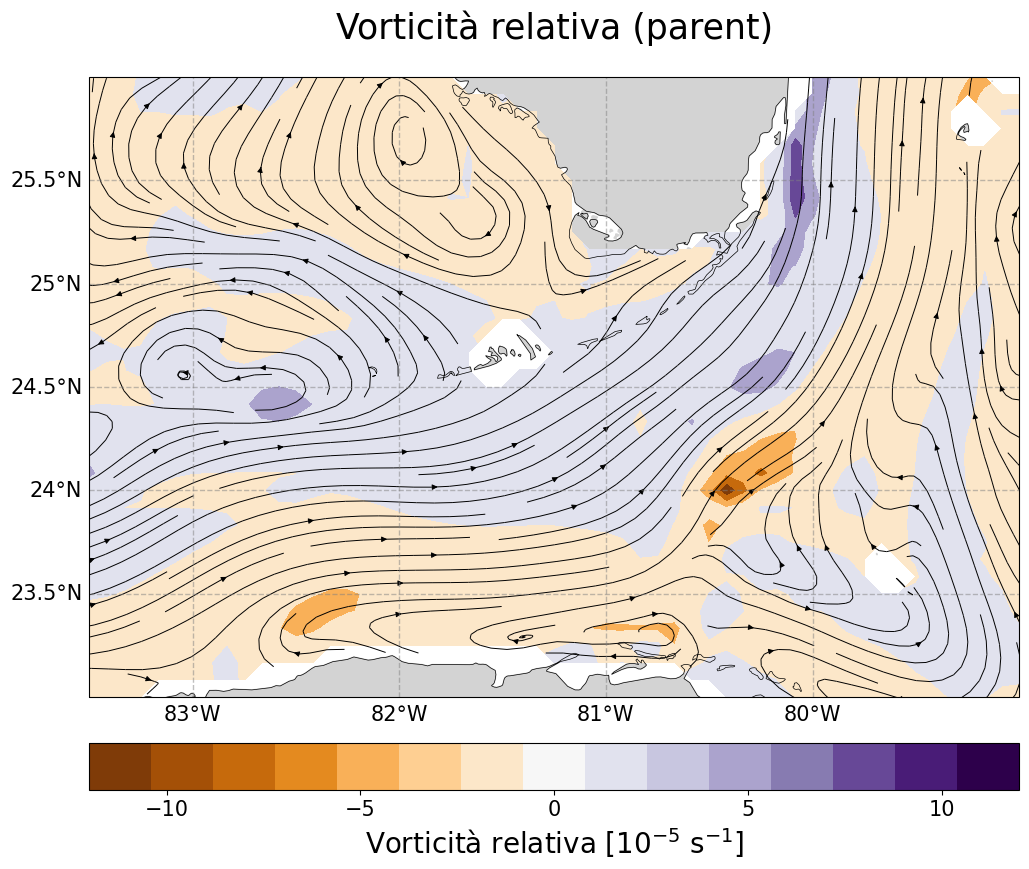

In [41]:
fig, ax = set_plot()

cmap = plt.get_cmap("PuOr", 15)
ax.contourf(lon_2d, lat_2d, vort_par*100000, cmap = cmap, norm = Normalize(-12,12))

c = ScalarMappable(Normalize(-12,12), cmap=cmap)
cb = set_cbar(c, "Vorticità relativa [10$^{-5}$ s$^{-1}$]")


set_streamlines(ax, lon_2d, lat_2d, u_parent, v_parent, density = 2)

ax.set_xlim([-83.5, -79])
ax.set_ylim([23, 26])

title_set(ax, "Vorticità relativa (parent)")


fig.savefig("vorticity_parent.pdf", bbox_inches = "tight")

# Temperatura superficiale

In [54]:
#open NetCDF file
pathname = "."
file_nc = "SURF_1h_20210202_20210206_grid_T.nc"
ncin = Dataset(pathname + "/" + file_nc, 'r')

#read mask values
file_mask = 'mesh_mask.nc'
ds_mask = Dataset(file_mask, 'r')
#take variables at the surface
mask_T = ds_mask.variables['tmask'][0,:,:,:]
mask_z = ds_mask.variables['mbathy'][0,:,:]


#read lat, lon e temp
lon = ncin.variables['nav_lon'][:,:]
lat = ncin.variables['nav_lat'][:,:]
#take temp only last day of simulation t = 120 => each day 120:5 = 24 steps, one per hour
temp = np.where(mask_T==0, float('nan'), ncin.variables['votemper'][96:,:,:,:]) #time (120), depth, lat, lon

#compute dayli mean
t_mean = np.mean(temp, axis = 0)
t_surf = t_mean[0,:,:]

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


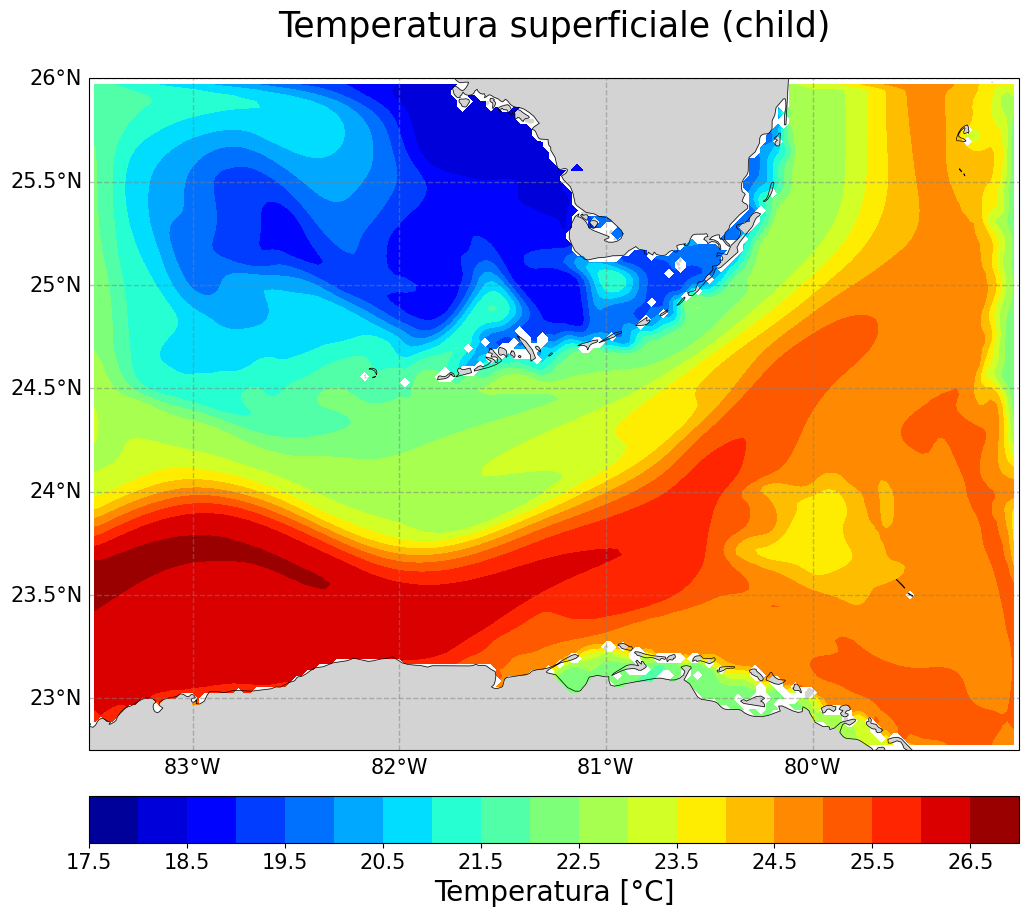

In [55]:
fig, ax = set_plot()

c = ax.contourf(lon, lat, t_surf, transform = ccrs.PlateCarree(), cmap = "jet", levels = 20)
set_cbar(c, "Temperatura [°C]")

title_set(ax, "Temperatura superficiale (child)")

fig.savefig("sst.pdf", bbox_inches = "tight")

C:\Users\feder\AppData\Local\Temp\ipykernel_6832\73774881.py:24: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(c, pad = 0.05, orientation = "horizontal")


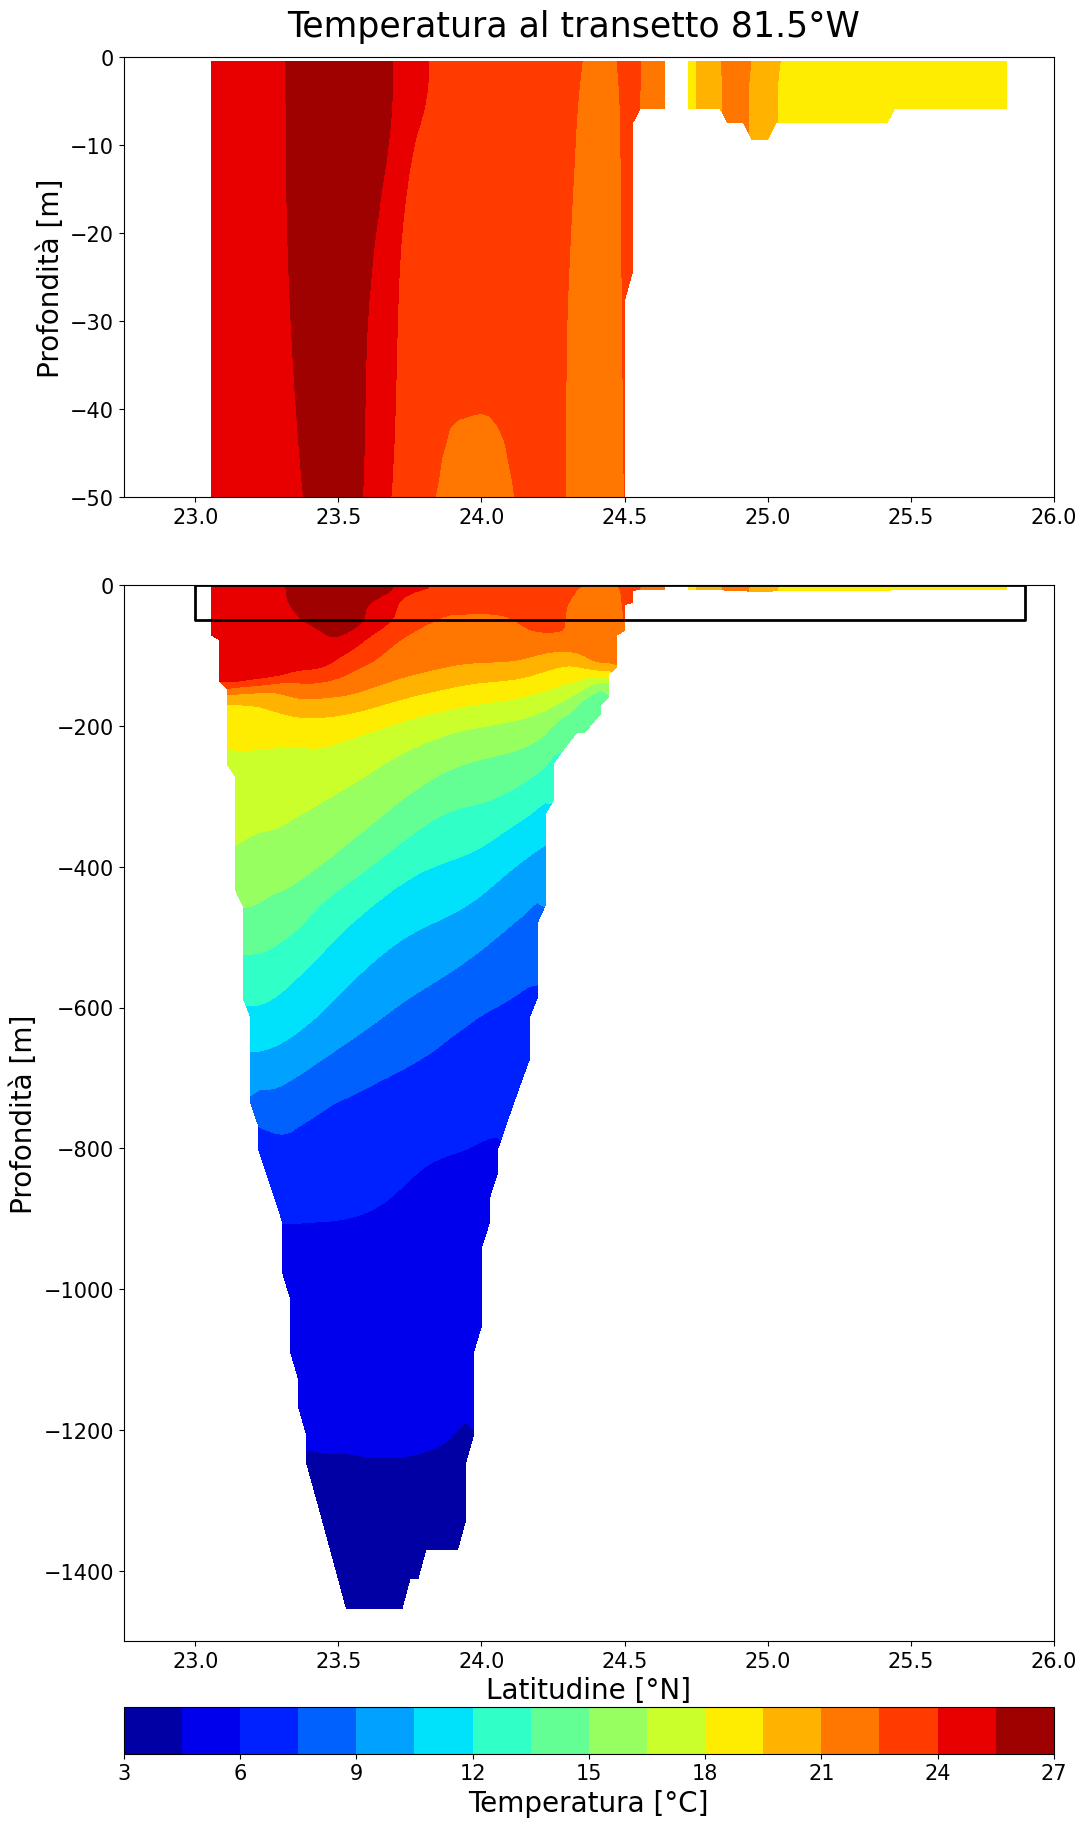

In [63]:

#open NetCDF file
pathname = "."
file_nc = "SURF_1h_20210202_20210206_grid_T.nc"
ncin = Dataset(pathname + "/" + file_nc, 'r')

#read mask values
file_mask = 'mesh_mask.nc'
ds_mask = Dataset(file_mask, 'r')
mask_T = ds_mask.variables['tmask'][0,:,:,:]
mask_z = ds_mask.variables['mbathy'][0,:,:]


#read lat, lon e temp
lon = ncin.variables['nav_lon'][:,:]
lat = ncin.variables['nav_lat'][:,:]
#take temp only last day of simulation t = 120 => each day 120:5 = 24 steps, one per hour
temp = np.where(mask_T==0, float('nan'), ncin.variables['votemper'][96:,:,:,:]) #time (120), depth, lat, lon

#########TRANSETTO MERIDONALE A LON = -81.5, colonna 72 della longitudine
depth = ncin.variables['deptht'][:]
temp_bathy =np.where(mask_T==0, float('nan'), ncin.variables['votemper'][95:119,:,:,:])

temp_bathy1 = temp_bathy[0,:,:,72]
t_mean_bathy = np.mean(temp_bathy, axis = 0)#time (120), depth, lat, lon
t_transet = t_mean_bathy[:,:,72] 
lat_T = lat[:,0]

fig2, bx = plt.subplots(2,1, gridspec_kw={'height_ratios' : [1,3]}, figsize=(12,24))

scalar2 = bx[1].contourf(lat_T, -depth,  t_transet, 20, cmap = 'jet')

bx[1].set_xlabel('Latitudine [°N]', fontsize = 20)
bx[1].set_ylabel('Profondità [m]', fontsize = 20)
bx[1].set_ylim(-1500,0)
bx[1].tick_params("both", labelsize = 15)

las, lan = 23, 25.9
lou, loe = 0, -50
x = [lan, lan, las, las, lan]
y = [lou, loe, loe, lou, lou]
bx[1].plot(x,y, color = 'black', linewidth = 2.0)
fig2.suptitle("Temperatura al transetto 81.5°W", fontsize = 25, y=0.9)



scalar2 = bx[0].contourf(lat_T, -depth,  t_transet, 20, cmap = 'jet')
#axes
bx[0].set_ylabel('Profondità [m]', fontsize = 20)
bx[0].set_xlim(lat_T[0], lat_T[117])
bx[0].set_ylim(-50,0)
bx[0].tick_params("both", labelsize = 15)

#color bar
cbar = set_cbar(scalar2, "Temperatura [°C]") 
plt.subplots_adjust(hspace=0.1)
fig2.savefig('t_transet.pdf', bbox_inches='tight')


# Mixed layer

In [56]:
#read mask values
file_mask = 'mesh_mask.nc'
ds_mask = Dataset(file_mask, 'r')
#take variables at the surface
mask_T = ds_mask.variables['tmask'][0,0,:,:]

pathname = "."
file_nc = "SURF_1h_20210202_20210206_grid_T.nc"
ncin = Dataset(pathname + "/" + file_nc, 'r')

#read lat, lon e temp
lon = ncin.variables['nav_lon'][:,:]
lat = ncin.variables['nav_lat'][:,:]
#take temp only last day of simulation t = 120 => each day 120:5 = 24 steps, one per hour
mld = np.where(mask_T==0, float('nan'), ncin.variables['somxl010'][96:,:,:]) #time (120), lat, lon
mld_mean = np.mean(mld, axis = 0)


c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


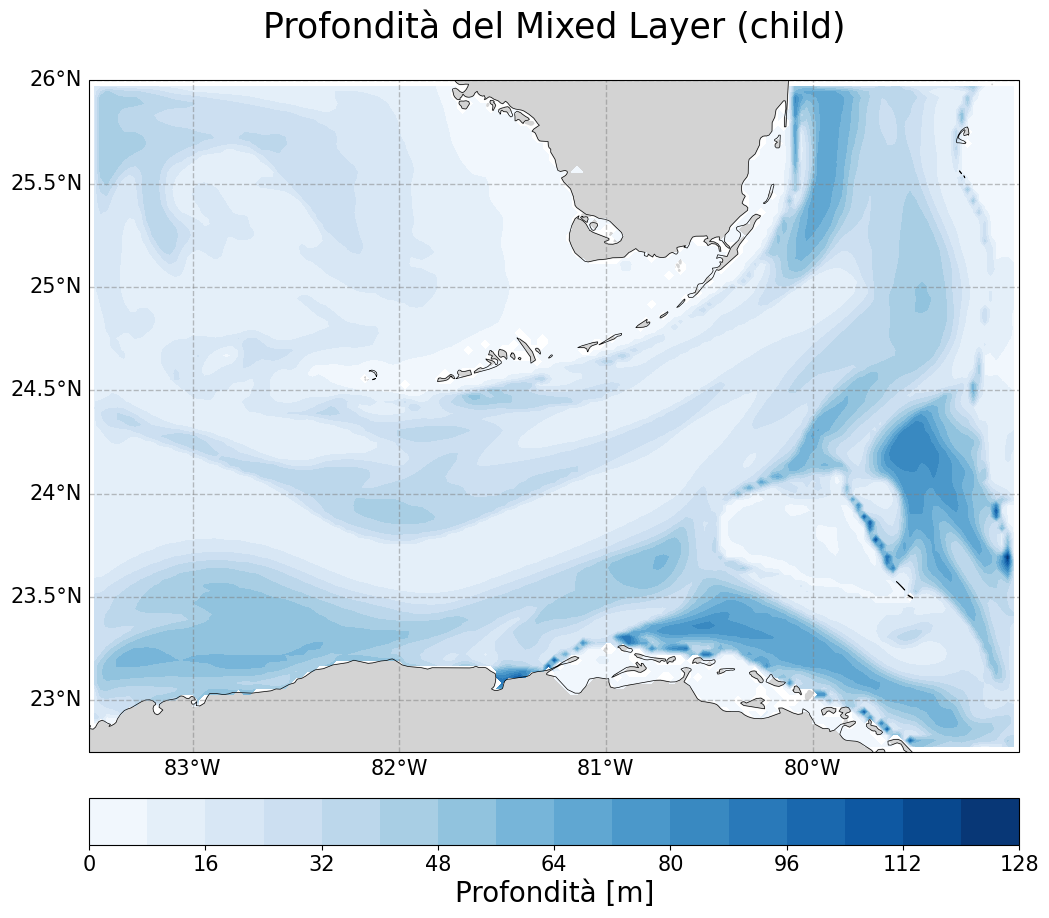

In [57]:
fig, ax = set_plot()
norm = Normalize(10, 130)
c = ax.contourf(lon, lat, mld_mean, levels = 15, cmap = "Blues", transform = ccrs.PlateCarree()) #20 levels of colors

set_cbar(c, "Profondità [m]")
title_set(ax, "Profondità del Mixed Layer (child)")

fig.savefig("mld_depth.pdf", bbox_inches = "tight")


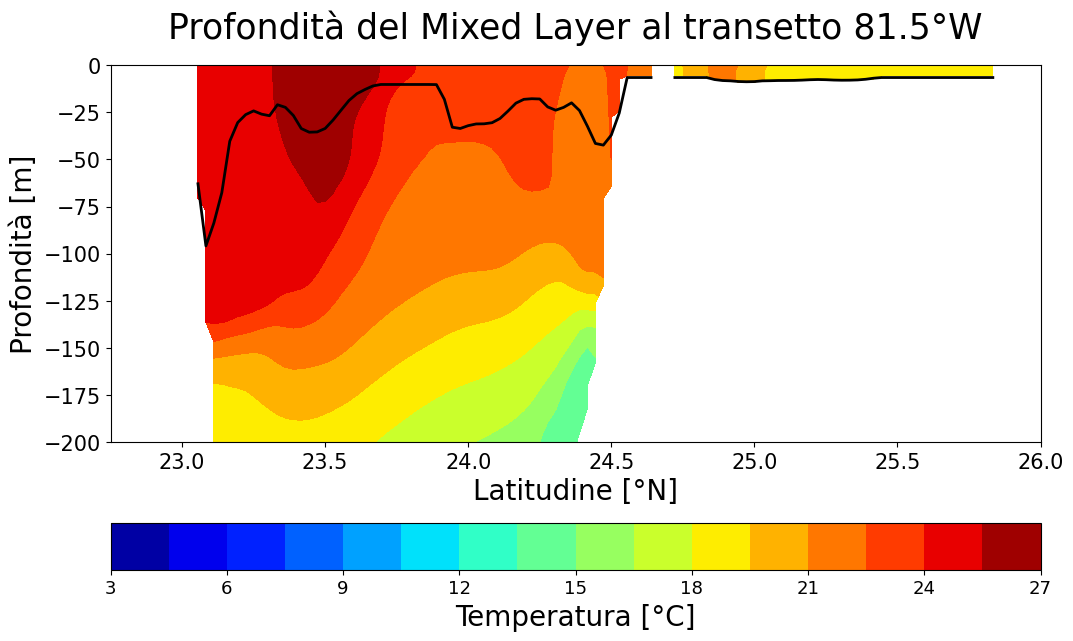

In [58]:
#########TRANSETTO MERIDONALE A LON = -81.5, colonna 72 della longitudine
depth = ncin.variables['deptht'][:]
mask_T2 = ds_mask.variables['tmask'][0,:,:,:]
temp_bathy = np.where(mask_T2==0, float('nan'), ncin.variables['votemper'][95:119,:,:,:]) 

temp_bathy1 = temp_bathy[0,:,:,72]
t_mean_bathy = np.mean(temp_bathy, axis = 0)#time (120), depth, lat, lon
t_transet = t_mean_bathy[:,:,72] 
lat_T = lat[:,0]

mld_transet = mld_mean[:,72]

fig2, bx = plt.subplots(figsize = (12,7))

scalar2 = bx.contourf(lat_T, -depth,  t_transet, 20, cmap = 'jet')
bx.plot(lat_T, -mld_transet, color='k', linewidth = 2.0)

cbar = plt.colorbar(scalar2, orientation = 'horizontal', pad = 0.15) #pad space between cbar and image
cbar.set_label('Temperatura [°C]', fontsize = 20) 
cbar.ax.tick_params(labelsize = 13)

bx.set_xlabel('Latitudine [°N]', fontsize = 20)
bx.set_ylabel('Profondità [m]', fontsize = 20)
bx.tick_params("both", labelsize = 15)
bx.set_ylim(-200,0)
title_set(bx, "Profondità del Mixed Layer al transetto 81.5°W")
fig2.savefig('mld_transet.pdf', bbox_inches='tight')

# Batimetria

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


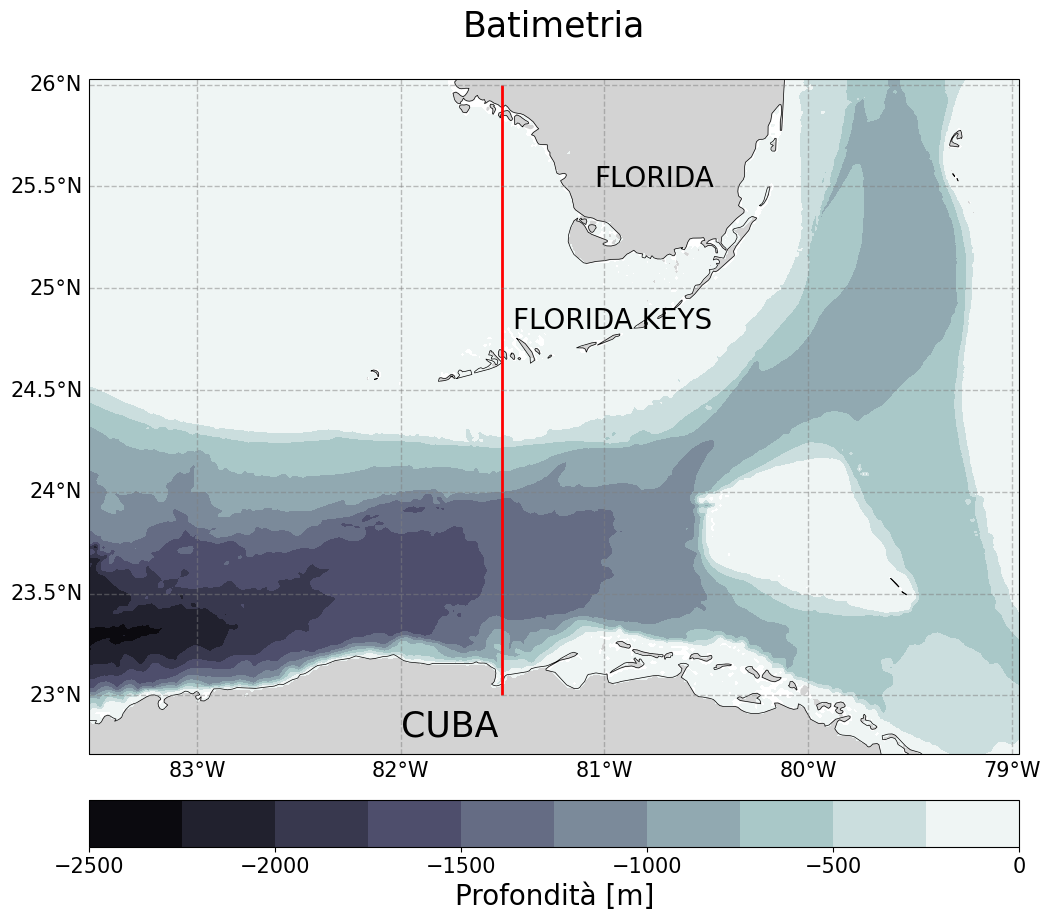

In [59]:
file_nc = "GEBCO_2014_2D.nc"
ncin = Dataset(pathname + "/" + file_nc, 'r')

# #read lat, lon e temp
lon = ncin.variables['lon'][:]
lat = ncin.variables['lat'][:]

el = ncin.variables['elevation'][:,:]
depth = np.where(el>0, float('nan'), ncin.variables['elevation'][:,:])

fig, ax = set_plot()
scalar = ax.contourf(lon, lat, depth, 10, cmap = 'bone',  transform = ccrs.PlateCarree()) #20 levels of colors
ax.vlines(x=-81.5, ymin=23, ymax=26, colors='red', lw=2)

cb = set_cbar(scalar, "Profondità [m]")

title_set(ax, "Batimetria")

ax.text(x = -81.05, y = 25.5, s = "FLORIDA", transform = ccrs.PlateCarree(), size = 20)
ax.text(x = -82, y = 22.8, s = "CUBA", transform = ccrs.PlateCarree(), size = 25)
ax.text(x = -81.45, y = 24.8, s = "FLORIDA KEYS", transform = ccrs.PlateCarree(), size = 20)


fig.savefig('bathy.pdf', bbox_inches='tight')